# Working with numerical data

In the previous notebook, we trained a k-nearest neighbors model on
some data.

However, we oversimplified the procedure by loading a dataset that contained
exclusively numerical data. Besides, we used datasets which were already
split into train-test sets.

In this notebook, we aim at:

* identifying numerical data in a heterogeneous dataset;
* selecting the subset of columns corresponding to numerical data;
* using a scikit-learn helper to separate data into train-test sets;
* training and evaluating a more complex scikit-learn model.

We will start by loading the adult census dataset used during the data
exploration.

## Loading the entire dataset

As in the previous notebook, we rely on pandas to open the CSV file into
a pandas dataframe.

In [31]:
import seaborn as sns
%load_ext autotime
from joblib import parallel_backend


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-09-15 17:20:19 +02:00)


In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")
# drop the duplicated column `"education-num"` as stated in the first notebook
adult_census = adult_census.drop(columns="education-num")
adult_census.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


The next step separates the target from the data. We performed the same
procedure in the previous notebook.

In [2]:
data, target = adult_census.drop(columns="class"), adult_census["class"]

In [3]:
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


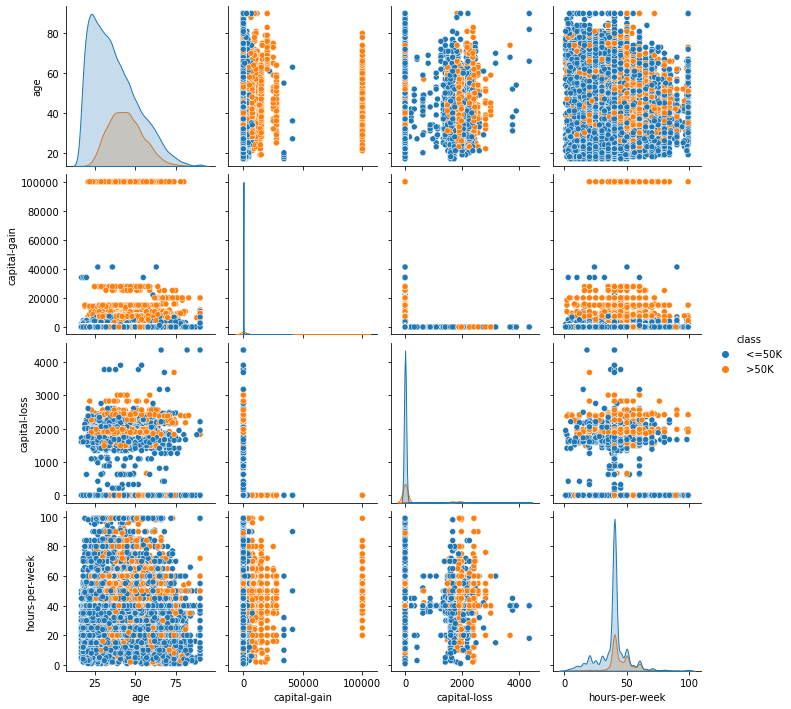

In [7]:
sns.pairplot(adult_census, hue="class")

In [4]:
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Here and later, we use the name <tt class="docutils literal">data</tt> and <tt class="docutils literal">target</tt> to be explicit. In
scikit-learn documentation, <tt class="docutils literal">data</tt> is commonly named <tt class="docutils literal">X</tt> and <tt class="docutils literal">target</tt> is
commonly called <tt class="docutils literal">y</tt>.</p>
</div>

At this point, we can focus on the data we want to use to train our
predictive model.

## Identify numerical data

Numerical data are represented with numbers. They are linked to measurable
(quantitative) data, such as age or the number of hours a person works a
week.

Predictive models are natively designed to work with numerical data.
Moreover, numerical data usually requires very little work before getting
started with training.

The first task here will be to identify numerical data in our dataset.

<div class="admonition caution alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p class="last">Numerical data are represented with numbers, but numbers are not always
representing numerical data. Categories could already be encoded with
numbers and you will need to identify these features.</p>
</div>

Thus, we can check the data type for each of the column in the dataset.

In [8]:
data.dtypes

age                int64
workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

We seem to have only two data types. We can make sure by checking the unique
data types.

In [9]:
data.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

Indeed, the only two types in the dataset are integer and object.
We can look at the first few lines of the dataframe to understand the
meaning of the `object` data type.

In [10]:
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


We see that the `object` data type corresponds to columns containing strings.
As we saw in the exploration section, these columns contain categories and we
will see later how to handle those. We can select the columns containing
integers and check their content.

In [11]:
numerical_columns = ["age", "capital-gain", "capital-loss", "hours-per-week"]
data[numerical_columns].head()

,age,capital-gain,capital-loss,hours-per-week
0,25,0,0,40
1,38,0,0,50
2,28,0,0,40
3,44,7688,0,40
4,18,0,0,30


Now that we limited the dataset to numerical columns only,
we can analyse these numbers to figure out what they represent. We can
identify two types of usage.

The first column, `"age"`, is self-explanatory. We can note that the values
are continuous, meaning they can take up any number in a given range. Let's
find out what this range is:

In [12]:
data["age"].describe()

count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

We can see the age varies between 17 and 90 years.

We could extend our analysis and we will find that `"capital-gain"`,
`"capital-loss"`, and `"hours-per-week"` are also representing quantitative
data.

Now, we store the subset of numerical columns in a new dataframe.

<AxesSubplot:>

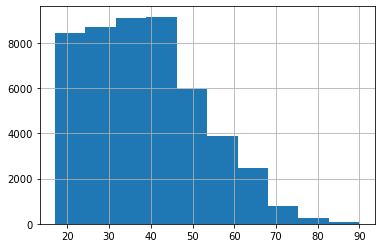

In [13]:
data['age'].hist()

In [14]:
data_numeric = data[numerical_columns]

## Train-test split the dataset

In the previous notebook, we loaded two separate datasets: a training one and
a testing one. However, having separate datasets in two distincts files is
unusual: most of the time, we have a single file containing all the data that
we need to split once loaded in the memory.

Scikit-learn provides the helper function
`sklearn.model_selection.train_test_split` which is used to automatically
split the dataset into two subsets.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, random_state=42, test_size=0.25)

time: 16 ms (started: 2022-09-15 17:00:57 +02:00)


<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">In scikit-learn setting the <tt class="docutils literal">random_state</tt> parameter allows to get
deterministic results when we use a random number generator. In the
<tt class="docutils literal">train_test_split</tt> case the randomness comes from shuffling the data, which
decides how the dataset is split into a train and a test set).</p>
</div>

When calling the function `train_test_split`, we specified that we would like
to have 25% of samples in the testing set while the remaining samples (75%)
will be available in the training set. We can check quickly if we got
what we expected.

In [16]:
print(f"Number of samples in testing: {data_test.shape[0]} => "
      f"{data_test.shape[0] / data_numeric.shape[0] * 100:.1f}% of the"
      f" original set")

Number of samples in testing: 12211 => 25.0% of the original set


In [17]:
print(f"Number of samples in training: {data_train.shape[0]} => "
      f"{data_train.shape[0] / data_numeric.shape[0] * 100:.1f}% of the"
      f" original set")

Number of samples in training: 36631 => 75.0% of the original set


In the previous notebook, we used a k-nearest neighbors model. While this
model is intuitive to understand, it is not widely used in practice. Now, we
will use a more useful model, called a logistic regression, which belongs to
the linear models family.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>In short, linear models find a set of weights to combine features linearly
and predict the target. For instance, the model can come up with a rule such
as:</p>
<ul class="simple">
<li>if <tt class="docutils literal">0.1 * age + 3.3 * <span class="pre">hours-per-week</span> - 15.1 &gt; 0</tt>, predict <tt class="docutils literal"><span class="pre">high-income</span></tt></li>
<li>otherwise predict <tt class="docutils literal"><span class="pre">low-income</span></tt></li>
</ul>
<p class="last">Linear models, and in particular the logistic regression, will be covered in
more details in the "Linear models" module later in this course. For now the
focus is to use this logistic regression model in scikit-learn rather than
understand how it works in details.</p>
</div>

To create a logistic regression model in scikit-learn you can do:

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)

time: 0 ns (started: 2022-09-15 17:01:02 +02:00)


Now that the model has been created, you can use it exactly the same way as
we used the k-nearest neighbors model in the previous notebook. In
particular, we can use the `fit` method to train the model using the training
data and labels:

In [34]:
model.fit(data_train, target_train)

LogisticRegression(n_jobs=-1)

time: 985 ms (started: 2022-09-15 17:22:14 +02:00)


In [33]:
with parallel_backend('threading', n_jobs=-1):
    model.fit(data_train, target_train)

time: 109 ms (started: 2022-09-15 17:22:08 +02:00)


We can also use the `score` method to check the model generalization performance
on the test set.

In [25]:
accuracy = model.score(data_test, target_test)
print(f"Accuracy of logistic regression: {accuracy:.3f}")

Accuracy of logistic regression: 0.807
time: 32 ms (started: 2022-09-15 17:01:12 +02:00)


In scikit-learn, the `score` method of a classification model returns the accuracy,
i.e. the fraction of correctly classified samples. In this case, around
8 / 10 of the times, the logistic regression predicts the right income of a
person. Now the real question is: is this generalization performance relevant
of a good predictive model? Find out by solving the next exercise!

In this notebook, we learned to:

* identify numerical data in a heterogeneous dataset;
* select the subset of columns corresponding to numerical data;
* use the scikit-learn `train_test_split` function to separate data into
  a train and a test set;
* train and evaluate a logistic regression model.